In [2]:
# Import required modules\n
# For NewsAPI
import requests
import numpy as np
import pandas as pd
import csv

# For Individual Feature Extraction 
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import re
from collections import Counter

# For Relational Feature Extraction
from statistics import mean
import math

# For feature analyzation
#enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell

# increase size of output window
from IPython.core.display import display, HTML

# import libraries
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# For machine learning
from sklearn import svm
from sklearn.svm import SVC

# Modeling
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Evaluation
from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Cross-validation
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Saving
import joblib
from joblib import dump, load

# READING DATASET

In [71]:
def read_data(fileName):
    
    header = ["ID", "label", "description", 'subject', 'speaker', 'speaker_job', 'state_info', 'party_aff', 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire', 'context']
    data = pd.read_csv(f"./datasets/liar_dataset/{fileName}", delimiter = '\t', names = header, encoding = 'unicode_escape')
    return data

#Statement = data['statement']
#Label = data['label']

def subject_set(data, Set):

    subject_list = []
    temp = []
    subject = data['subject']
    subject = subject.tolist()
    for element in subject:
        try:
            for i in element.split(','):
                temp.append(i)
        except:
            pass

    subject_set = set(temp)
    Set.update(subject_set)
    return Set

def drop_null(data):
    # drop the null values (if both content and description are null)
    data = data.dropna(how = 'any')
    for i in range(len(data)):
        try:
            if (len(data['description'][i]) == 0):
                data = data.drop(i)
            else:
                pass
        except:
            pass
    return data

In [38]:
def news_api(topic, number, source):
    # List creation
    source_id = []
    author = []
    title = []
    description = []
    url = []
    content = []
    pub_date = []
    rel = []

    # Read 100 news articles about coronavirus (20 articles per each page, 5 pages) and parse each data into corresponding lists
    for i in range(1, int((number/20)+1)):

        # News extraction
        news_url = ('https://newsapi.org/v2/everything?'
                f'domains={source}&'
                f'q={topic}&'
               f'page={i}&'
               'sortBy=popularity&'
               'apiKey=963417ea47cd41199fcbae1e1189b85b')

        
        news = requests.get(news_url)
        
        #print((news.json()['totalResults']))
        #print(news.json())
        
        try:
            for elements in news.json()['articles']:
                source_id.append(elements['source']['id'])
                author.append(elements['author'])
                title.append(elements['title'])
                description.append(elements['description'])
                url.append(elements['url'])
                content.append(elements['content'])
                pub_date.append(elements['publishedAt'])
        except:
            print(news.json())
            
            # *For CNN Only: check if the content is video and data does not related to the article
            #if (elements['content'] == 'None' or elements['content'] == \"Chat with us in Facebook Messenger. Find out what's happening in the world as it unfolds.\"):
            #    pass
                #print(elements['description'])
            #else:
                #print (elements['content'])
            #    pass
    
    # Test for parsed data
    #print(author)
    news_info = pd.DataFrame()
    news_info['source_id'] = source_id
    news_info['author'] = author
    news_info['title'] = title
    news_info['description'] = description
    news_info['url'] = url
    news_info['content'] = content
    news_info['published_date'] = pub_date
    
    drop_null(news_info)
    
    return news_info
    
    
#news = news_api('economy', 100, 'www.cbc.ca', '2020-01-30', 1)
#text = news_api('economy', 100, 'youtube.com, wsj.com', '2020-01-30', 0)

#ref = news_api('economy', 100, 'cnn.com', '2020-01-30', 1)

#print(news['description'].head(5)

In [5]:
# Create the lists of the words that used for feature extraction

positive_list = list()
negative_list = list()

# Gather the positive and negative word lists from the text file
with open('./word_sentiment/positive-words.txt') as p:
    for line in p:
        val = line.split()
        for ele in val:
            positive_list.append(ele)

with open('./word_sentiment/negative-words.txt') as n:
    for line in n:
        val = line.split()
        for ele in val:
            negative_list.append(ele)

subjective_list = list(['am', 'are', 'is', 'was', 'were', 'be', 'been'])
causation_list = list(['led to', 'because', 'cause', 'caused', 'reason', 'explanation', 'so'])

exclusive_list = list(['except', 'else', 'besides', 'without', 'exclude', 'other than'])
generalizing_list = list(['all', 'none', 'most', 'many', 'always', 'everyone','never',
                          'some','usually','few','seldom','generally','general','overall'])
pronoun_1st_list = list(['I','we'])
pronoun_2nd3rd_list = list(['you','your','yours','he','she','it','him','her','his','her','its','hers','They','them','theirs','their'])

SPronoun_list = list(['I', 'mine','my','me'])
GPronoun_list = list(['we','ours','our','us'])

In [39]:
# From the dataset, isolate the required data (statement and label in this program) and return as pandas Series
# If the user needs the required data as a file, uncomment def with new_file as argument and comment the other one

#def setup_data(file_name, new_file):
def setup_data(news_info):
    
    # Check for data reading
    #print(news_info.head(5))
    
    # Check for the raw data from original dataset
    # print (list(data.columns.values))
    # print(data.tail(1))

    data = pd.DataFrame()
    news_contents = []
    label_list = []
    subject_list = []
    
    for elements in range(len(news_info)):
        description = news_info.loc[elements, 'description']
        label = news_info.loc[elements, 'label']
        subject = news_info.loc[elements, 'subject']
        
        label = label.lower().replace("half-true", '1')
        label = label.lower().replace("mostly-true", '1')
        label = label.lower().replace("pants-fire", '0')
        label = label.lower().replace("barely-true", '0')
        label = label.lower().replace("true", '1')
        label = label.lower().replace("false", '0')
        
        # uncomment and indent the news_contents.append(description) line if both contents and descriptions are used instead of  description only
        
        #content = data.loc[elements, 'content']
        #if not pd.isna(content) and content is \"Chat with us in Facebook Messenger. Find out what's happening in the world as it unfolds.\":
        #    news_contents.append(content)
        #else:
        news_contents.append(description)
        label_list.append(label)
        subject_list.append(subject)
    
    data['description'] = news_contents
    data['label'] = label_list
    data['subject'] = subject_list
    
    #try:
    for i in range(len(data)):
        data['label'][i] = int(data['label'][i])
    #except:
    #    print('something passed')
    
    
    
    return data

# Data Extraction
# From the dataset file, gather the news contents and labels only

#text_data = setup_data(text)
#news_data = setup_data(news)
#ref_data = setup_data(ref)

#print(text_data.head(5))
#print(news_data.head(5))

def setup_ref(subject_list):
    counter = 0
    news_dic = {}
    for subject in subject_list:
        #print(subject)
        subject_data = news_api(subject, 20, "cnn.com")
        news_dic[subject] = subject_data
    return news_dic
    

#######################################
# Operator

train = read_data('train.tsv')
test = read_data('test.tsv')
valid = read_data('valid.tsv')

subject = set()

train_sub = subject_set(train, subject)
test_sub = subject_set(test, subject)
valid_sub = subject_set(valid, subject)

train = setup_data(train)
test = setup_data(test)
valid = setup_data(valid)

#print(train.head(5))
#print(test.head(5))
#print(valid.head(5))

subject_list = []

for i in subject:
    subject_list.append(i)

#subject1 = news_api(subject_list[0], 100, "cnn.com")
#subject2 = news_api(subject_list[1], 100, "cnn.com")

#news_dic = {}

#news_dic[subject_list[0]] = subject1
#news_dic[subject_list[1]] = subject2

#print(subject_list)



In [40]:
# DO NOT COMPILE THIS PART TWICE A DAY!!!


sub_data = setup_ref(subject_list)

In [214]:
#print(sub_data)

clone = sub_data
print(subject_list)
counter = 0
for subject in subject_list:
    if(clone[subject].empty):
        #clone[subject] = clone['economy']
        clone.drop[clone[subject]]
        print('hey')
    else:
        #print('hey')
        pass

['redistricting', 'autism', 'legal-issues', 'environment', 'homeland-security', 'state-finances', 'education', 'recreation', 'after-the-fact', 'animals', 'state-budget', 'medicaid', 'polls', 'florida', 'transportation', 'fires', 'infrastructure', 'guns', 'history', 'agriculture', 'public-health', 'gas-prices', 'Alcohol', 'islam', 'occupy-wall-street', 'debates', 'immigration', 'food-safety', 'weather', 'kagan-nomination', 'congress', 'bankruptcy', 'taxes', 'iraq', 'death-penalty', 'campaign-advertising', 'abortion', 'government-efficiency', 'population', 'candidates-biography', 'ebola', 'criminal-justice', '10-news-tampa-bay', 'message-machine', 'wealth', 'afghanistan', 'drugs', 'religion', 'lottery', 'energy', 'diversity', 'patriotism', 'urban', 'sexuality', 'city-government', 'hunger', 'social-security', 'unions', 'transparency', 'city-budget', 'congressional-rules', 'cap-and-trade', 'medicare', 'trade', 'workers', 'obama-birth-certificate', 'economy', 'voting-record', 'supreme-court

In [81]:
# Input: String ('str')
# Description: Tockenize and tag input with nltk universal tag
# Return: tags of each tockens - String ('tagged')
# Tockenize and tag input String with nltk universal tag and return the tags for each words in the String

def tagging_univ(str):
    text = nltk.word_tokenize(str)
    tagged = nltk.pos_tag(text, tagset='universal')
    return tagged

# Input: String('str')
# Description: Tockenize and tag input with nltk non-universal tag
# Return: tags of each tockens - String ('tagged')

def tagging_nuniv(str):
    text = nltk.word_tokenize(str)
    tagged = nltk.pos_tag(text)
    return tagged

# Input: String('str')
# Description: Count the number of characters in input
# Return: Character count - int ('count')

def count_char(str):
    no_space = str.replace(" ", "")
    count = len(no_space)
    return count

# Input: String('str')
# Description: Count the number of words in input
# Return: Word count - int ('count')

def count_word(str):
    count = len(str.split())
    return count

# Input: String ('str')
# Description: Count the number of sentences by counting number of period(.)
# Return: Sentence count - int ('sentence')

def count_sent(str):
    sentence = len(str.split('.'))
    return sentence

# Input: String ('states')
# Description: Count the number of characters in each word in input and average the number of characters per word
# Return: Average number of characters: float ('avg')

def count_char_per_word(states):
    word = []
    word.append(states.split())
    char_per_word = list()
    for elements in word:
        for char in elements:
            c_in_w_count = len(char)
            char_per_word.append(c_in_w_count)
    # char_per_word_list.append()
    avg = sum(char_per_word) / len(char_per_word)
    char_per_word.clear()
    return avg

# Input: String ('tagged'), String ('tag'), count ('int')
# Description: Count the number of specified tags ('tag') from the input
# Return: Count of specified tag - int ('int')

def check_tag(check, tag, count):
    if check == tag:
        count += 1
    return count

# Input: String ('tagged'), list ('list'), int ('int')
# Description: Count the number of common words between input String and input list
# Return: Count of common words - int ('int')
# Count and return the number of words that is included in the given list in the statement

def check_common(state, list, count):
    #for ele in list:
    #    count = tagged.count(ele)
    #return count
    for elements in list:
        for words in state.split():
            if words == elements:
                count += 1
    return count

# Input: String ('word'), String ('tag'), list ('subjective_list'), int ('sent_count')
# Description: Count the number of passive voice and avarge it from number of sentence (sent_count)
# Return: Average of passive voiced sentences - float ('result')

def count_passive(word, tag, subjective_list, sent_count):
    percent_sub = 0
    counter = 0
    for ele in subjective_list:
        if (word.count(ele) > 0 and tag == "VBN"):
            counter += 1
    result = counter / sent_count * 100
    return result

# Input: String ('states')
# Description: Count the words that introduced only once in input
# Return: Count of unique words - int ('unique_count')

def count_unique(states):
    words = states.split(' ')
    c = Counter(words)
    unique = [w for w in words if c[w] == 1]
    unique_counter = len(unique)
    return unique_counter

# Calvin
def avg_char(states):
    word.append(states.split())
    char_per_word = list()
    for elements in word:
        for char in elements:
            c_in_w_count = len(char)
            char_per_word.append(c_in_w_count)
    word.clear()
    avg = sum(char_per_word)/len(char_per_word)
    char_per_word.clear()
    return avg


# Input: panda Series ('data'), String ('save_file_name')
# Description: First, this function creates lists for each features and extract the features using statements in dataset and
#              above functions. Next, it creates a large pandas Series that consist of news contents, labels and extracted
#              features. Finally, it save the final pandas Series in a file to make easier to examine the result (do not need
#              to rerun the program or change the code to check raw data)
# Return: Pandas Series consist of news contents, labels and extracted features count - pandas Series ('new')

def feature_extract(data):
    # define the news contents and labels from the dataset
    state = data['description']
    #label = data['label']
    #subject = data['subject']
    
    # Create a dataframe that will store every feature values
    ind_feature = pd.DataFrame()

    # create lists for storing the counters
    char_count_list = list()
    word_count_list = list()
    verb_count_list = list()
    noun_count_list = list()
    sent_count_list = list()
    words_per_sent_list = list()
    char_per_word_list = list()
    quest_count_list = list()
    sub_count_list = list()
    pass_count_list = list()
    pos_count_list = list()
    neg_count_list = list()
    unique_count_list = list()
    typo_count_list = list()
    cause_count_list = list()
    
    # Calvin
    gene_count_list = list()
    num_count_list = list()
    pron_1st_count_list = list()
    pron_2nd3rd_count_list = list()
    exclu_count_list = list()
    
    # Andrew
    exclam_list = list()
    lex_list = list()
    singlulars_list = list()
    group_list = list()
    other_list = list()


    word = list()

    #print(type(state))
    # loop for checking each new contents in dataset
    for states in state:

        #print(states)
        # reset the counters for each news contents
        w_in_s_count = 0
        c_in_w_count = 0
        verb_count = 0
        noun_count = 0
        sub_count = 0
        pos_count = 0
        neg_count = 0
        percent_pos = 0
        percent_neg = 0
        unique_count = 0
        sent_counts = 0
        typo_count = 0
        cause_count = 0
        gene_count = 0
        pron_1st_count = 0
        pron_count = 0
        exclu_count = 0
        SelfP = 0
        count_prongroup = 0
        group = 0
        other = 0
        num= 0
        
        # Tockenization and tagging with nltk universal and non-universal tag systems (tagged = universal, tagged_nu = non-universal)
        tagged = tagging_univ(states)
        tagged_nu = tagging_nuniv(states)

        # Check the tags of each news contents
        # print(tagged)
        # print(tagged_nu)

        # Extract the features and append the results in the list. Commented lines with print() functions are for testing

        # 1. Number of Characters
        char_count = count_char(states)
        char_count_list.append(char_count)

        # 2. Nubmer of Words
        word_count = count_word(states)
        word_count_list.append(word_count)

        # 3. Number of Verbs
        for tag in tagged:
            verb_count = check_tag(tag[1], 'VERB', verb_count)
        verb_count_list.append(verb_count)

        # 4. Number of Nouns
        for tag in tagged:
            noun_count = check_tag(tag[1], 'NOUN', noun_count)
        noun_count_list.append(noun_count)
        # print(noun_count)

        # 5. Number of Sentence
        sent_count = count_sent(states)
        sent_count_list.append(sent_count)
        # print(sent_count)

        # 6. Average number of words per sentence
        sent = [len(l.split()) for l in re.split(r'[?!.]', states) if l.strip()]
        w_in_s_count = (sum(sent) / len(sent))
        words_per_sent_list.append(w_in_s_count)
        # print(w_in_s_count)

        # 7. Average number of characters per word
        c_in_w_count = count_char_per_word(states)
        char_per_word_list.append(c_in_w_count)
        # print(c_in_w_count)

        # 8. Number of question marks
        quest_count = states.count("?")
        quest_count_list.append(quest_count)

        # 9. Percentage of subjective verbs - am/are/is/etc
        sub_count = check_common(states, subjective_list, sub_count)
        if (verb_count > 0):
            percent_sub = sub_count / verb_count * 100
        sub_count_list.append(percent_sub)

        # 10. Percentage of passive voice - am/are/is && past participate
        for tag in tagged_nu:
            passive_percent = count_passive(tag[0], tag[1], subjective_list, sent_count)
        pass_count_list.append(passive_percent)

        # 11. Percentage of positive words
        for tag in tagged:
            pos_count = check_common(tag[0], positive_list, pos_count)
            percent_pos = pos_count / word_count * 100
        pos_count_list.append(percent_pos)

        # 12. Percentage of negative words
        for tag in tagged:
            neg_count = check_common(tag[0], negative_list, neg_count)
            percent_neg = neg_count / word_count * 100
        neg_count_list.append(percent_neg)

        # 13. Lexical diversity: unique words or terms
        unique_count = count_unique(states)
        unique_count_list.append(unique_count)

        # 14. Typographical error ratio: misspelled words
        for tag in tagged:
            typo_count = check_tag(tag[1], 'X', typo_count)
        typo_count_list.append(typo_count)

        # 15. Causation terms
        cause_count = check_common(states, causation_list, cause_count)
        cause_count_list.append(cause_count)

        # 16. Percentage of generalizing terms
        gene_count = check_common(states, generalizing_list, gene_count)
        gene_count_list.append(gene_count)
        
        # 17. Percentage of numbers and quantifiers
        for tag in tagged:
            num = check_tag(tag[1], 'NUM', num)
        num_count_list.append(num)

        # 18. 1st person pronouns
        pron_1st_count = check_common(states, pronoun_1st_list, pron_1st_count)
        pron_1st_count_list.append(pron_1st_count)
   
        # 19. 2nd and 3rd person pronouns
        pron_count = check_common(states, pronoun_2nd3rd_list, pron_count)
        pron_2nd3rd_count_list.append(pron_count)

        # 20. Exclusive terms
        exclu_count = check_common(states, exclusive_list, exclu_count)
        exclu_count_list.append(exclu_count)
        
        # 21. # of exclamation marks
        exclam_count = states.count("!")
        exclam_list.append(exclam_count)
        
        # 22. lexical 
        unique_count = count_unique(states)
        lex_list.append(unique_count)
        
        # 23. singlular pronouns (1st person)
        SelfP = check_common(states, SPronoun_list, SelfP)
        singlulars_list.append(SelfP)
        
        # 24. Group ref pronouns (1st person)
        group = check_common(states, GPronoun_list, group)
        group_list.append(group)
        
        # 25. 2nd 3rd pronouns
        other = check_common(states, pronoun_2nd3rd_list, other)
        other_list.append(other)
        

    # Put the data into a dataframe
        
    #ind_feature['Statement'] = state
    #ind_feature['Label'] = label
    #ind_feature['Subject'] = subject
    ind_feature['# of Characters'] = char_count_list
    ind_feature['# of Words'] = word_count_list
    ind_feature['# of Verbs'] = verb_count_list
    ind_feature['# of Noun'] = noun_count_list
    ind_feature['# of Sentence'] = sent_count_list
    ind_feature['Average # of Words per Sentence'] = words_per_sent_list
    ind_feature['Average # of Characters per Words'] = char_per_word_list
    ind_feature['# of Question Marks'] = quest_count_list
    ind_feature['% of Subjective Verbs'] = sub_count_list
    ind_feature['% of Passive Voice'] = pass_count_list
    ind_feature['% of Positive Words'] = pos_count_list
    ind_feature['% of Negative Words'] = neg_count_list
    ind_feature['# of Unique Wrods/Terms'] = unique_count_list
    ind_feature['# of Misspelled Words'] = typo_count_list
    ind_feature['# of Causation Terms'] = cause_count_list
    ind_feature['% of generalizing terms'] = gene_count_list
    ind_feature['% of # and quantifiers'] = num_count_list
    ind_feature['1st person pronouns'] = pron_1st_count_list
    ind_feature['2nd and 3rd person pronouns'] = pron_2nd3rd_count_list
    ind_feature['Exclusive term'] = exclu_count_list
    ind_feature['# of exclamation marks'] = exclam_list
    ind_feature['Lexical'] = lex_list
    ind_feature['Singular pronouns(1st person)'] = singlulars_list
    ind_feature['Group ref pronouns(1st person)'] = group_list
    ind_feature['2nd 3rd pronouns'] = other_list

    return ind_feature


########################################################################################################################

# Feature Extraction

#text_data_FE = feature_extract(text)

# Checking data

#print(text_data_FE.head(5)

#training_features = feature_extract(train)
#test_features = feature_extract(test)
#valid_features = feature_extract(valid)


In [166]:
data_ref = {}
for subject in subject_list:
    clone[subject] = drop_null(clone[subject])
    data_ref[subject] = feature_extract(clone[subject])
#print(data_ref['jobs'])
#print(data_ref['immigration'].tail(5))


    # of Characters  # of Words  # of Verbs  # of Noun  # of Sentence  \
0               145          27           5         15              2   
1               196          32           6         12              2   
2               219          42           7         16              1   
3               221          40          10         10              2   
4               203          40           4         17              2   
5               218          43          11         16              2   
6               217          44           6         14              2   
7               222          39           5         18              1   
8               114          24           3         10              3   
9               218          37           7         15              2   
10              141          25           5         12              3   
11              183          36           7         11              3   
12              167          34           5        

# Relational Features

In [290]:
# Subtract each feature values for each data in the same row (one-to-one). List contains
# the extracted feature values related to texts. Ex. feature_list[0] = all feature values of first statement
# In case of there is null in the reference data, use two next reference data

def one_to_one_dif(text, ref, feature_name, subject_list):
    feature_list = []
    feature = 0
    for i in range (len(text)):
        try:
            #subject = subject_list.iloc[i].split(',')
            subject = ['economy']
        except:
            subject = ['economy']
            
        try:
            feature = (float(text[feature_name][i]) - float(ref[subject[0]][feature_name][0]))
            #print('no error')
        except:
            try:
                feature = (float(text[i]) - float(ref[i+2]))
                #print('maybe here?')
            except:
                #print(ref)
                print('error here')
                pass

        feature_list.append(round(feature, 2))
    return feature_list
    
# Subtract each feature values for each data in the same row and repeat it with different references.(one-to-many)
# Then, average the difference. List contains the extracted feature values related to texts.
# Ex. final_list[0] = all feature values of first statement
# In case of there is null in the reference data, use two next reference data

def one_to_many_dif(text, ref, feature_name, subject_list):
    
    final_list = []
    
    
    for i in range(len(text)):
        try:
            #subject = subject_list.iloc[i].split(',')
            subject = ['economy']
        except:
            subject = ['economy']
            
        avg_list = []
        
        for k in range(len(subject)):
            for j in range(len(ref[subject[k]])):
                try:
                    feature_val = float(text[feature_name][i]) - float(ref[subject[k]][feature_name][j])
                except:
                    try:
                        feature_val = float(text[feature_name][i]) - float(ref[subject[k]][feature_name][j+2])
                    except:
                        print('damn it')
                        pass
                avg_list.append(feature_val)
                
        avg = round(mean(avg_list), 2)
        final_list.append(avg)
    return final_list
    
    
# Input: news1 (String), news2 (String), outFile (String), startFColumn (integer)
# Description: Read the data from news1 (reliable) and news2 (unreliable), and put the data in two lists. Then, subtract the news1 values in each column from news2 values.
#              The subtraction starts from startFColumn until the end of the .csv file. Next, the results will be saved in the file with given name or path from user (outFile)
#
# Return: New DataFrame ('MS_features')

def multi_source_FE(text, ref):

    # Saving original headers in header
    #header = list(text)
    
    source = "cnn.com"
    
    # Only feature values
    #cols = [col for col in text.columns if col not in ['Statement', 'Label', 'Subject']]
    
    state_text = text['description']
    subject_text = text['subject']
    label_text = text['label'].astype(int)
    
    data_text = feature_extract(text)
        
        
    #for subject in subject_text:
    #    print(subject.split(","))
        
    #print(data_text)
    
    row_counter = 0
    
    # = 42
    #print(data_text['# of Characters'][0])
    
    #print(subject_text[0])
    #ref = news_api('economy', 100, source)
    #ref = drop_null(ref)
    #ref_data = feature_extract(ref)
    #ref_data
    #print(ref_data)
    
    
    
    data_ref_list = {}
    one_to_one = {}
    
    #print(data_ref)
    #for feature_name in data_text:
        #print(subject_text.iloc[row_counter])
        
        #print(feature_name)
        #print(subject_list)
            #subject = subject_text.split(',')
        #print(subject[0])
        
        #one_to_one[feature_name] = one_to_one_dif(data_text, data_ref, feature_name, subject_text)
        
        
        

        
            #for i in range(len(data_text)):
                #print(data_text[])

        #print(data_text[k][text_data_row])
        #print(k)
    

    
    
    #data_ref = ref[cols]

    feature_num = len(data_text.keys())


    # Create local lists, dataframe that are used later in this definition.
    df = pd.DataFrame()
    sub = pd.DataFrame()
    avg_sub = pd.DataFrame()
    text = []
    ref = []
    total_list = []
    new_total_list = []
    
    # Loop through the data for subtraction
    for feature_name in data_text.keys():
        sub[feature_name + "- sub"] = one_to_one_dif(data_text, data_ref, feature_name, subject_text)
        avg_sub[feature_name + "- avg sub"] = one_to_many_dif(data_text, data_ref, feature_name, subject_text)
    
    # Creating dataframe with multi-sourced features
    df['Statement'] = state_text
    df['Label'] = label_text
    
    # Concatenate the text, reference and features, then drop null values
    df1 = pd.concat([df, data_text, sub, avg_sub], axis = 1)
    df1 = df1.dropna(how = 'any')
    
    return df1

# Initiate the code and check for the dataframe
train_feature = multi_source_FE(train, data_ref)
test_feature = multi_source_FE(test, data_ref)
valid_feature = multi_source_FE(valid, data_ref)

#print(text_feature.head(5))
#print(news_feature.head(5))

In [401]:
print(train_feature.head(5))
print(test_feature.head(5))
print(valid_feature.head(5))

                                           Statement  Label  # of Characters  \
0  Says the Annies List political group supports ...      0               72   
1  When did the decline of coal start? It started...      1              118   
2  Hillary Clinton agrees with John McCain "by vo...      1               87   
3  Health care reform legislation is likely to ma...      0               67   
4  The economic turnaround started at the end of ...      1               45   

   # of Words  # of Verbs  # of Noun  # of Sentence  \
0          11           2          6              2   
1          24           5          9              3   
2          19           3          9              2   
3          12           2          7              2   
4          10           1          3              2   

   Average # of Words per Sentence  Average # of Characters per Words  \
0                        11.000000                           6.545455   
1                         8.333333        

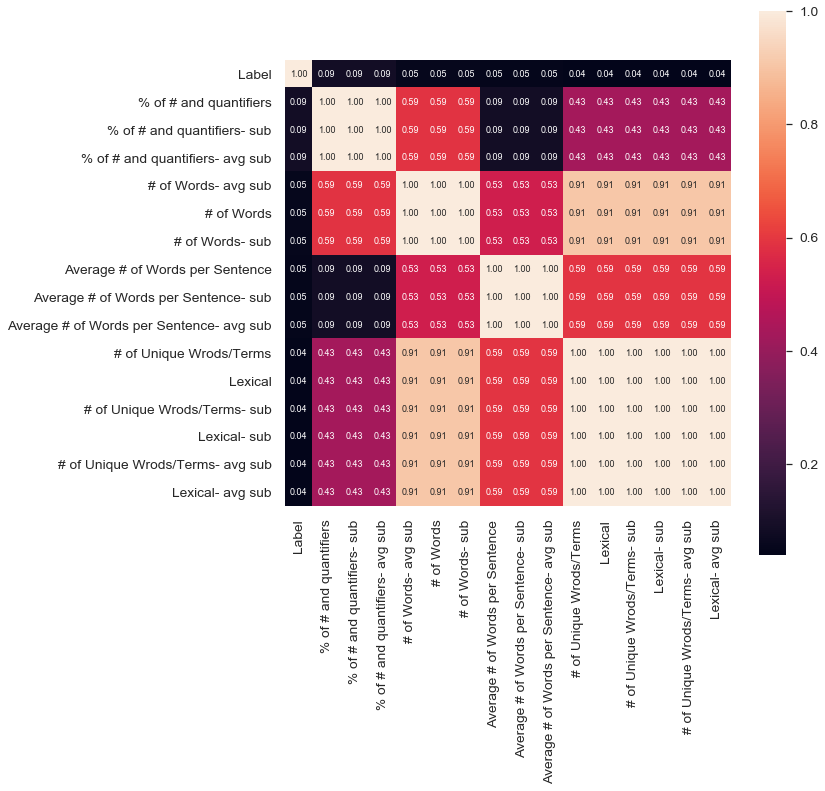

In [400]:
corrmat = train_feature.corr()

k = 16 #number of variables for heatmap
cols_cor = corrmat.nlargest(k, 'Label')['Label'].index
cm = np.corrcoef(train_feature[cols_cor].values.T)
sns.set(font_scale=1.25)
fig, ax = plt.subplots(figsize=(10,10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 9}, yticklabels=cols_cor.values, xticklabels=cols_cor.values, ax = ax)
plt.show()

In [395]:
cols_cor = [col for col in cols_cor if col not in ['Statement', 'Label']]

X_train = train_feature[cols_cor]
Y_train = train_data['Label']
X_test = test_feature[cols_cor]
Y_test = test_feature['Label']
X_valid = valid_feature[cols_cor]
Y_valid = valid_feature['Label']

print(X_train.head(5))


   % of # and quantifiers  % of # and quantifiers- sub  \
0                       0                          0.0   
1                       0                          0.0   
2                       0                          0.0   
3                       0                          0.0   
4                       0                          0.0   

   % of # and quantifiers- avg sub  # of Words- avg sub  # of Words  \
0                            -0.08               -26.17          11   
1                            -0.08               -13.17          24   
2                            -0.08               -18.17          19   
3                            -0.08               -25.17          12   
4                            -0.08               -27.17          10   

   # of Words- sub  Average # of Words per Sentence  \
0            -23.0                        11.000000   
1            -10.0                         8.333333   
2            -15.0                        10.000000   
3   

In [396]:
# Create pipeline for Gaussian NB
pipeline = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors = None))
#pred_nb = pipeline.fit(x_train, y_train).predict(x_test)

neigh = KNeighborsClassifier(n_neighbors = 3)
#pred_KN = neigh.fit(x_train, y_train).predict(x_test)

In [397]:
pred_gnb = pipeline.fit(X_train, Y_train).predict(X_test)

print("GNB Accuracy: ", accuracy_score(Y_test, pred_gnb))
print("GNB F1 Score: ", f1_score(Y_test, pred_gnb))

pred_kn = neigh.fit(X_train, Y_train).predict(X_test)
print("KNeighbors Accuracy: ", accuracy_score(Y_test, pred_kn))
print("KNeighbors F1 Score: ", f1_score(Y_test, pred_kn))

print(cross_val_score(neigh, X_test, Y_test, scoring = 'accuracy', cv=10))
print(cross_val_score(neigh, X_valid, Y_valid, scoring = 'accuracy', cv=10))

GNB Accuracy:  0.5027624309392266
GNB F1 Score:  0.41774491682070236
KNeighbors Accuracy:  0.5311760063141279
KNeighbors F1 Score:  0.6292134831460674
[0.484375   0.46875    0.6328125  0.55905512 0.47619048 0.47619048
 0.50793651 0.48412698 0.51587302 0.53174603]
[0.50387597 0.57364341 0.53488372 0.54263566 0.60465116 0.42635659
 0.484375   0.484375   0.55905512 0.55905512]


In [389]:
cols_full = [col for col in train_feature.columns if col not in ['Statement', 'Label']]

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=10)
#print(abs(train_feature[cols]))

fit = bestfeatures.fit(abs(train_feature[cols_full]),Y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_feature[cols_full].columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Score']  #naming the dataframe columns
select = featureScores.nlargest(15,'Score')

In [398]:
cols_chi = select['Features']
X_train = train_feature[cols]
#print(X_train.head(5))
print(cols)

['% of # and quantifiers', '% of # and quantifiers- avg sub', '% of # and quantifiers- sub', '# of Words', 'Average # of Words per Sentence', '# of Unique Wrods/Terms', 'Lexical', '# of Characters', 'Group ref pronouns(1st person)- avg sub', 'Group ref pronouns(1st person)- sub', '% of Subjective Verbs- avg sub', 'Group ref pronouns(1st person)', '# of Sentence', '% of generalizing terms', '# of Misspelled Words- sub']


In [399]:
X_train = train_feature[cols_chi]
Y_train = train_data['Label']
X_test = test_feature[cols_chi]
Y_test = test_feature['Label']
X_valid = valid_feature[cols_chi]
Y_valid = valid_feature['Label']


# Create pipeline for Gaussian NB
pipeline = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors = None))
pred_nb = pipeline.fit(X_train, Y_train).predict(X_test)

neigh = KNeighborsClassifier(n_neighbors = 3)
pred_KN = neigh.fit(X_train, Y_train).predict(X_test)

pred_gnb = pipeline.fit(X_train, Y_train).predict(X_test)

print("GNB Accuracy: ", accuracy_score(Y_test, pred_gnb))
print("GNB F1 Score: ", f1_score(Y_test, pred_gnb))

pred_kn = neigh.fit(X_train, Y_train).predict(X_test)
print("KNeighbors Accuracy: ", accuracy_score(Y_test, pred_kn))
print("KNeighbors F1 Score: ", f1_score(Y_test, pred_kn))

print(cross_val_score(neigh, X_test, Y_test, scoring = 'accuracy', cv=10))
print(cross_val_score(neigh, X_valid, Y_valid, scoring = 'accuracy', cv=10))


GNB Accuracy:  0.49329123914759276
GNB F1 Score:  0.37669902912621356
KNeighbors Accuracy:  0.5232833464877664
KNeighbors F1 Score:  0.5734463276836157
[0.4921875  0.4921875  0.515625   0.48818898 0.57936508 0.50793651
 0.49206349 0.57142857 0.54761905 0.5       ]
[0.58914729 0.52713178 0.60465116 0.52713178 0.58914729 0.55813953
 0.59375    0.515625   0.57480315 0.47244094]
